In [ ]:
# Script to see how well your uncertainty scheme works for a given mechanism

In [13]:
import os
import sys
import pickle
import copy
import numpy as np
import rmgpy.chemkin
import rmgpy
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties
import rmgpy.exceptions

import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/home/moon/autoscience/reaction_calculator/database')
import database_fun

In [2]:
def get_node_std(rxns, family):
    if len(rxns) == 1:
        print('NO SIDT EST')
        return np.nan
#         return 1.329
    recipe = database.kinetics.families[family].forward_recipe

    rxns = np.array(rxns)

    label = ''
    Tref = 1000.0
    data_mean = np.mean(np.log([r.kinetics.get_rate_coefficient(Tref) for r in rxns]))

    n = len(rxns)

    dlnks = np.array([
        np.log(
            rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns[list(set(range(len(rxns))) - {i})], recipe=recipe.actions)
            .to_arrhenius(rxn.get_enthalpy_of_reaction(Tref))
            .get_rate_coefficient(T=Tref) / rxn.get_rate_coefficient(T=Tref)
        ) for i, rxn in enumerate(rxns)
    ])


    varis = (np.array([rmgpy.kinetics.uncertainties.rank_accuracy_map[rxn.rank].value_si for rxn in rxns]) / (2.0 * 8.314 * Tref)) ** 2
    # weighted average calculations
    ws = 1.0 / varis
    V1 = ws.sum()
    V2 = (ws ** 2).sum()
    mu = np.dot(ws, dlnks) / V1
    s = np.sqrt(np.dot(ws, (dlnks - mu) ** 2) / (V1 - V2 / V1))

    kin_uncertainty = rmgpy.kinetics.uncertainties.RateUncertainty(mu=mu, var=s ** 2, N=n, Tref=Tref, data_mean=data_mean, correlation=label)

    std_dev = kin_uncertainty.get_expected_log_uncertainty() / .398

    return std_dev

In [3]:
def reactions_in_same_direction(reactionA, reactionB):
    reactantsA = [x.smiles for x in reactionA.reactants]
    reactantsB = [x.smiles for x in reactionB.reactants]
        
    return reactantsA[0] in reactantsB

In [4]:
database = rmgpy.data.rmg.RMGDatabase()

thermo_libraries = [
    'Klippenstein_Glarborg2016',
    'BurkeH2O2',
    'thermo_DFT_CCSDTF12_BAC', 
    'DFT_QCI_thermo',
    'primaryThermoLibrary',
    'primaryNS',
    'NitrogenCurran',
    'NOx2018',
    'FFCM1(-)',
    'SulfurLibrary',
    'SulfurGlarborgH2S',
    'SABIC_aromatics',
]

database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = thermo_libraries,
    transport_libraries = [],
    reaction_libraries = [],
    seed_mechanisms = [],#['BurkeH2O2inN2','ERC-FoundationFuelv0.9'],
    kinetics_families = 'all',
    kinetics_depositories = ['training'],
    #frequenciesLibraries = self.statmechLibraries,
    depository = False, # Don't bother loading the depository information, as we don't use it
)

In [5]:
# Create a giant dictionary with all of the reaction family information in it
auto_gen_families = {}
for family_name in database.kinetics.families.keys():
    if family_name == 'Intra_R_Add_Endocyclic' or family_name == 'Intra_R_Add_Exocyclic':
        continue
    if database.kinetics.families[family_name].auto_generated and family_name not in auto_gen_families.keys():
        auto_gen_families[family_name] = database.kinetics.families[family_name].rules.get_entries()
        auto_gen_families[f'{family_name}_labels'] = [entry.label for entry in database.kinetics.families[family_name].rules.get_entries()]
        auto_gen_families[f'{family_name}_rxn_map'] = database.kinetics.families[family_name].get_reaction_matches(
            thermo_database=database.thermo,
            remove_degeneracy=True,
            get_reverse=True,
            exact_matches_only=False,
            fix_labels=True)


ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.419,128.588,135.2,140.503,147.924,152.211,155.919],'J/(mol*K)'), H298=(19.7155,'kJ/mol'), S298=(387.478,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(153.818,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsClClClCs) + longDistanceInteraction_noncyclic(Cs(Cl)3-Cs(Cl)2) + group(CsCsClClH) + radical(CsCl1sCl1sCs)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 2000.0 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([139.592,151.36,159.399,165.718,174.181,178.534,180.476],'J/(mol*K)'), H298=(-162.929,'kJ/mol'), S298=(391.397,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsClClClCs) + longDistanceInteraction_noncyclic(Cs(Cl)3-Cs(Cl)3) + group(CsClClClCs) + longDistanceInteraction_noncyclic(Cs(Cl)3-Cs(Cl)3)""").
The thermo for this species is probabl

In [9]:
# load aramco
aramco_chemkin_file = '/home/moon/autoscience/aramco/chem_annotated.inp'
aramco_dict_file = '/home/moon/autoscience/aramco/species_dictionary.txt'

species_listA, reaction_listA = rmgpy.chemkin.load_chemkin_file(aramco_chemkin_file, aramco_dict_file)


In [10]:
# load RMG-min-7
rmg_min_7_chemkin_file = '/home/moon/uncertainty_estimator/RMG-min-7/chem_annotated.inp'
rmg_min_7_dict_file = '/home/moon/uncertainty_estimator/RMG-min-7/species_dictionary.txt'

species_list7, reaction_list7 = rmgpy.chemkin.load_chemkin_file(rmg_min_7_chemkin_file, rmg_min_7_dict_file)


In [11]:
display(reaction_listA[280])

In [ ]:
def is_reverse()

# Plot the reactions in the mechanism

0
Reversing reaction


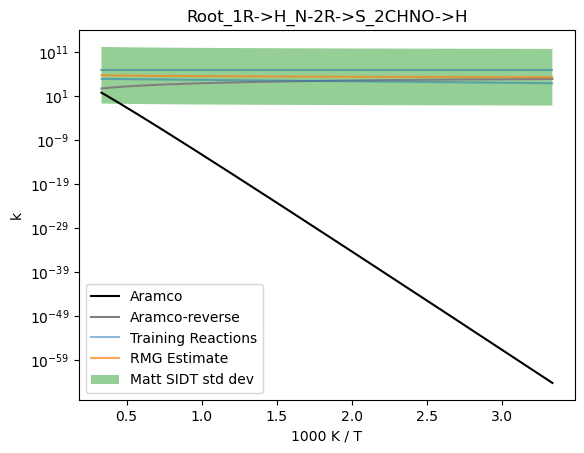

5


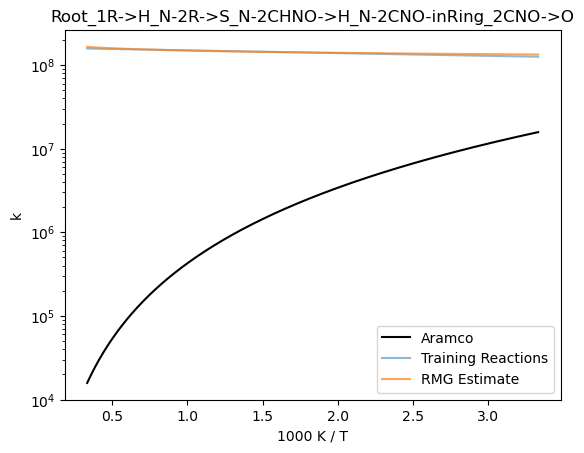

20
Reversing reaction


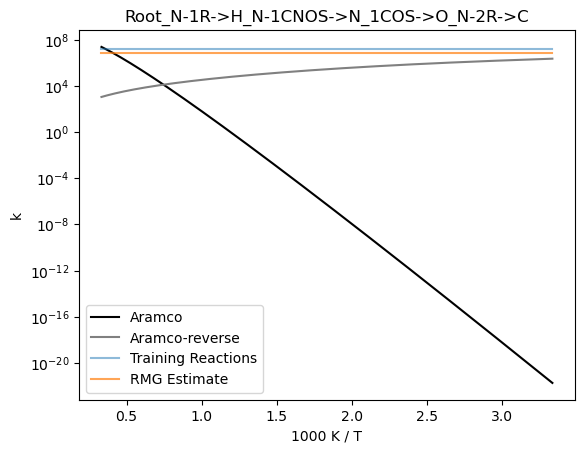

21


/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


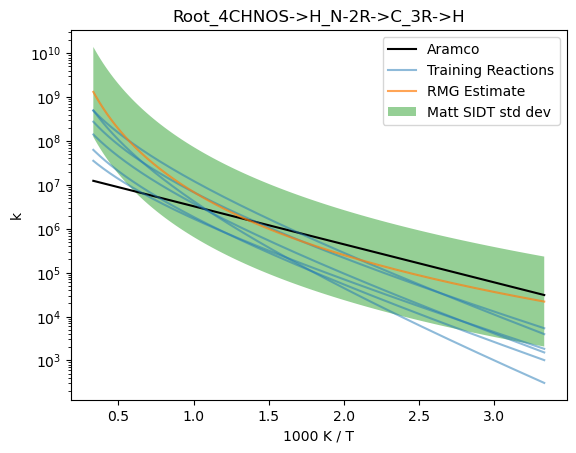

30


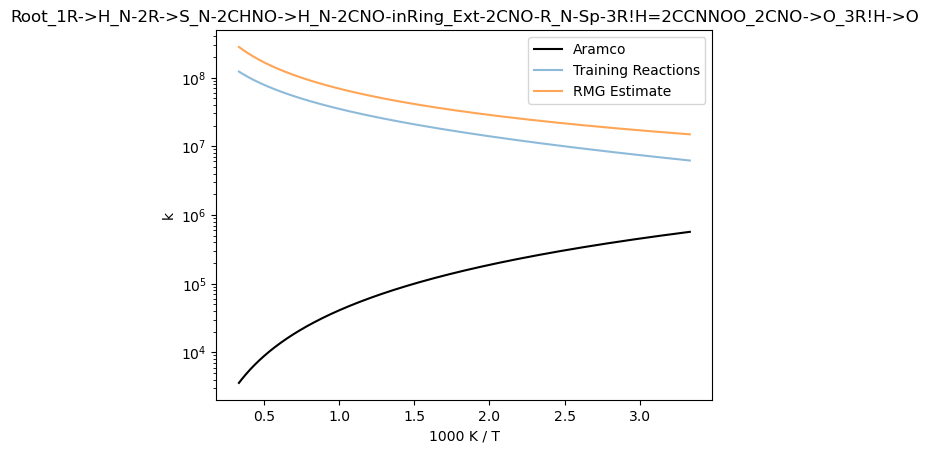

38


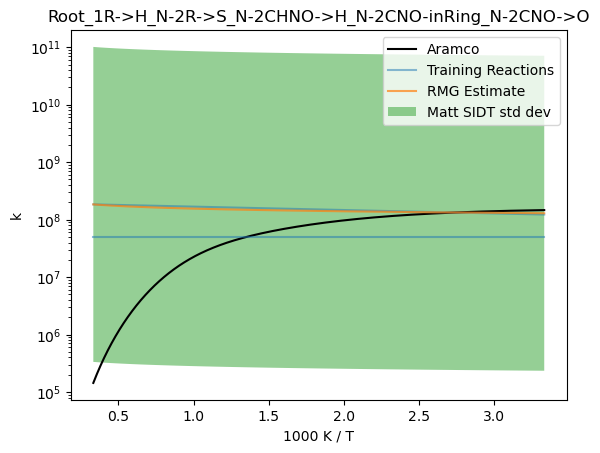

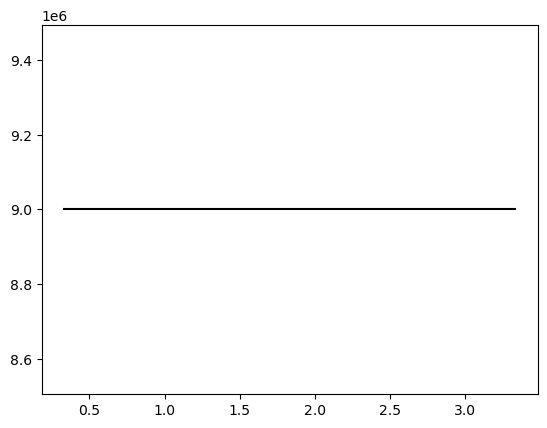

In [48]:
i = 280
# i = 124
# for i in disps[0:15]:

data_entry = {}

# collect data here and plot on next plot
SIDT_compare_idx = []
# RMG

# for i in range(500):
for i in range(50):
    my_rxn = copy.deepcopy(reaction_listA[i])
    plt.clf()
#     print(i)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    Tref = 1000.0
    T = np.linspace(300, 3000, 1001)
    P = 101325
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        k[j] = my_rxn.get_rate_coefficient(T[j], P)
    plt.plot(1000.0 / T, k, label=f'Aramco', color='black')

    fam_rxn_list = database.kinetics.generate_reactions_from_families(
        reactants=my_rxn.reactants,
        products=my_rxn.products,
        only_families=None,
        resonance=True,
    )
    if not fam_rxn_list:
#         print('No matches')
        continue

    family = fam_rxn_list[0].family
    if family not in auto_gen_families.keys():
#         print(f'{family} is not autogenerated')
        continue
    
    
    SIDT_compare_idx.append(i)
    print(i)
    if not fam_rxn_list[0].is_forward:
        # skipping reverse for now?
        my_rxn.reactants = reaction_listA[i].products
        my_rxn.products = reaction_listA[i].reactants
        print('Reversing reaction')
        
        # plot aramco in reverse
        rev_kinA = reaction_listA[i].generate_reverse_rate_coefficient()
        for j in range(0, len(T)):
            k[j] = rev_kinA.get_rate_coefficient(T[j], P)
        plt.plot(1000.0 / T, k, label=f'Aramco-reverse', color='grey')
        
    my_rxn.degeneracy = fam_rxn_list[0].degeneracy
        
    for family in [r.family for r in fam_rxn_list]:
        database.kinetics.families[family].add_atom_labels_for_reaction(my_rxn)

        template_labels = database.kinetics.families[family].get_reaction_template_labels(my_rxn)
        template = database.kinetics.families[family].retrieve_template(template_labels)

        kinetics = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=my_rxn.degeneracy)[0]
    
    

    # also plot Matt's uncertainty, which means we need the families/nodes
    node = template[0].label
    rxns = auto_gen_families[f'{family}_rxn_map'][node]
    for z in range(len(rxns)):
        rxn = rxns[z]
        k = np.zeros(len(T))
        for j in range(0, len(T)):
            assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
            k[j] = rxn.get_rate_coefficient(T[j])
        if z == 0:
            plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.5)
        else:
            plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.5)
        plt.yscale('log')

    k = np.zeros(len(T))
    arrh_kinetics = kinetics.to_arrhenius(my_rxn.get_enthalpy_of_reaction(1000))
    for j in range(0, len(T)):
#         k[j] = kinetics.get_rate_coefficient(T[j], my_rxn.get_enthalpy_of_reaction(T[j]))
        k[j] = arrh_kinetics.get_rate_coefficient(T[j])
    plt.plot(1000.0 / T, k, label=f'RMG Estimate', color=colors[1], alpha=0.7)


    if len(rxns) == 1:
#         print('NO SIDT EST')
        pass
    else:
        r = rmgpy.reaction.Reaction()
        r.kinetics = kinetics

        sigma_lnk = get_node_std(rxns, family)

    #     sigma_lnk = database.kinetics.families[family].extract_source_from_comments(r)[1][1]['node_std_dev']
        sigma_k = np.exp(sigma_lnk)
        plt.fill_between(1000.0 / T, k, k * sigma_k, alpha=0.5, color=colors[2], edgecolor=None, label='Matt SIDT std dev')
        plt.fill_between(1000.0 / T, k / sigma_k, k, alpha=0.5, color=colors[2], edgecolor=None)    

    plt.title(node)
    plt.xlabel ('1000 K / T')
    plt.ylabel('k')
    plt.yscale('log')
    plt.legend()
    plt.show()
    # gao_sigma_lnk = uncertainty.kinetic_input_uncertainties[i]
    # gao_sigma_k = np.exp(gao_sigma_lnk)


    # # Plot node std dev
    # plt.fill_between(1000.0 / T, k, k * gao_sigma_k, alpha=0.5, color=colors[1], edgecolor=None, label='Gao std dev')
    # plt.fill_between(1000.0 / T, k / gao_sigma_k, k, alpha=0.5, color=colors[1], edgecolor=None)





In [ ]:
reaction_listA[481]

In [46]:
reaction_listA[0].generate_reverse_rate_coefficient()

ThirdBody(arrheniusLow=Arrhenius(A=(3.08246e+08,'m^6/(mol^2*s)'), n=-1.80522, Ea=(4.1626,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2000,'K'), comment="""Fitted to 29 data points; dA = *|/ 1.07004, dn = +|- 0.00896166, dEa = +|- 0.0468497 kJ/mol"""), efficiencies={Molecule(smiles="CC"): 3.0, Molecule(smiles="O=C=O"): 3.8, Molecule(smiles="O"): 12.0, Molecule(smiles="[C-]#[O+]"): 1.9, Molecule(smiles="[H][H]"): 2.5, Molecule(smiles="[He]"): 0.83, Molecule(smiles="C"): 2.0})

In [ ]:
display(fam_rxn_list[0])

In [ ]:
display(my_rxn)

In [ ]:
my_rxn = copy.deepcopy(reaction_listA[481])

fam_rxn_list = database.kinetics.generate_reactions_from_families(
        reactants=my_rxn.reactants,
        products=my_rxn.products,
        only_families=None,
        resonance=True,
    )

print(fam_rxn_list[0].family)

In [ ]:
fam_rxn_list

In [ ]:
n = copy.deepcopy(my_rxn)

n.reactants = my_rxn.products
n.products = my_rxn.reactants

In [ ]:
reaction_listA[0].is_isomorphic(fam_rxn_list[0])

# Debug Individual Node Estimate

0
Reversing reaction


Ea_t= 0.0
Ea_t= 6276.0
my computed sigma is  14.830194859219088
Matts sigma is  15.086096086298205
Ea_est= 21600.0


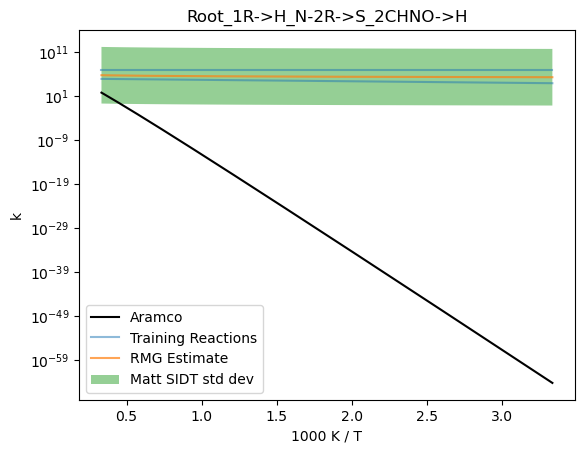

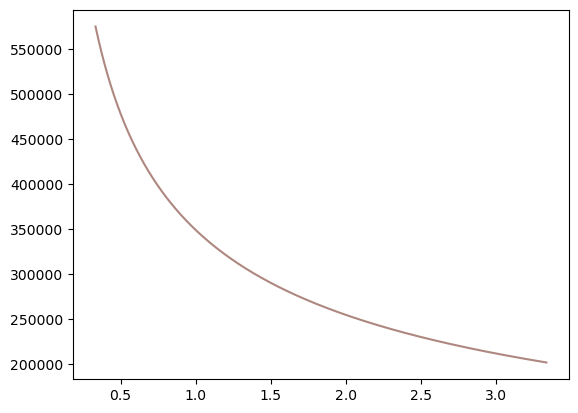

In [61]:
i = 0
print(i)
my_rxn = copy.deepcopy(reaction_listA[i])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
Tref = 1000.0
T = np.linspace(300, 3000, 1001)
P = 101325
k = np.zeros(len(T))
for j in range(0, len(T)):
    k[j] = my_rxn.get_rate_coefficient(T[j], P)
plt.plot(1000.0 / T, k, label=f'Aramco', color='black')

fam_rxn_list = database.kinetics.generate_reactions_from_families(
    reactants=my_rxn.reactants,
    products=my_rxn.products,
    only_families=None,
    resonance=True,
)
if not fam_rxn_list:
    print('No matches')

family = fam_rxn_list[0].family
if family not in auto_gen_families.keys():
    print(f'{family} is not autogenerated')


if not fam_rxn_list[0].is_forward:
    my_rxn.reactants = reaction_listA[i].products
    my_rxn.products = reaction_listA[i].reactants
    print('Reversing reaction')

my_rxn.degeneracy = fam_rxn_list[0].degeneracy
    
display(my_rxn)
for family in [r.family for r in fam_rxn_list]:
    database.kinetics.families[family].add_atom_labels_for_reaction(my_rxn)

    template_labels = database.kinetics.families[family].get_reaction_template_labels(my_rxn)
    template = database.kinetics.families[family].retrieve_template(template_labels)

    kinetics = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=my_rxn.degeneracy)[0]


# also plot Matt's uncertainty, which means we need the families/nodes
node = template[0].label
rxns = auto_gen_families[f'{family}_rxn_map'][node]
for z in range(len(rxns)):
    rxn = rxns[z]
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
        k[j] = rxn.get_rate_coefficient(T[j])
    if z == 0:
        plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.5)
    else:
        plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.5)
    plt.yscale('log')
    
#     print('n_t=', rxn.kinetics.n)
#     print('A_t=', rxn.kinetics.A.value_si)
    print('Ea_t=', rxn.kinetics.Ea.value_si)
#     print('H_t=', rxn.get_enthalpy_of_reaction(1000))

k = np.zeros(len(T))
for j in range(0, len(T)):
    k[j] = kinetics.get_rate_coefficient(T[j], my_rxn.get_enthalpy_of_reaction(T[j]))
plt.plot(1000.0 / T, k, label=f'RMG Estimate', color=colors[1], alpha=0.7)


if len(rxns) == 1:
    print('NO SIDT EST')

else:
    r = rmgpy.reaction.Reaction()
    r.kinetics = kinetics

    sigma_lnk = get_node_std(rxns, family)
    print('my computed sigma is ', sigma_lnk)
    s_matt = r.kinetics.uncertainty.get_expected_log_uncertainty() / .398
    print('Matts sigma is ', s_matt)
    
    
#     print('n_est=', kinetics.n)
#     print('A_est=', kinetics.A.value_si)
    print('Ea_est=', kinetics.E0.value_si)
#     print('H_est=', my_rxn.get_enthalpy_of_reaction(1000))
    
    sigma_k = np.exp(sigma_lnk)
    plt.fill_between(1000.0 / T, k, k * sigma_k, alpha=0.5, color=colors[2], edgecolor=None, label='Matt SIDT std dev')
    plt.fill_between(1000.0 / T, k / sigma_k, k, alpha=0.5, color=colors[2], edgecolor=None)    

plt.title(node)
plt.xlabel ('1000 K / T')
plt.ylabel('k')
plt.yscale('log')
plt.legend()
plt.show()
# gao_sigma_lnk = uncertainty.kinetic_input_uncertainties[i]
# gao_sigma_k = np.exp(gao_sigma_lnk)


# # Plot node std dev
# plt.fill_between(1000.0 / T, k, k * gao_sigma_k, alpha=0.5, color=colors[1], edgecolor=None, label='Gao std dev')
# plt.fill_between(1000.0 / T, k / gao_sigma_k, k, alpha=0.5, color=colors[1], edgecolor=None)


# also plot the predicted kinetics for one of the training reactions
train0 = copy.deepcopy(rxns[0])
kin0 = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=rxns[0].degeneracy)[0]
k = np.zeros(len(T))
for j in range(0, len(T)):
    k[j] = kin0.get_rate_coefficient(T[j], train0.get_enthalpy_of_reaction(T[j]))
plt.plot(1000.0 / T, k, label=f'RMG Est Train 0', color=colors[5], alpha=0.7)



# Record the data 

In [70]:
data_entries = []
data_entry = {}


Tdatas = [300, 1000, 1500]

for i in range(len(reaction_listA)):
    my_rxn = copy.deepcopy(reaction_listA[i])
    
    # get aramco or reverse aramco if applicable
    Tref = 1000.0
    P = 101325

    # get node estimate
    fam_rxn_list = database.kinetics.generate_reactions_from_families(
        reactants=my_rxn.reactants,
        products=my_rxn.products,
        only_families=None,
        resonance=True,
    )
    if not fam_rxn_list:
        continue

    family = fam_rxn_list[0].family
    if family not in auto_gen_families.keys():
        continue
    my_rxn.degeneracy = fam_rxn_list[0].degeneracy
    
    
    print(i)
    # get aramco kinetics in reverse if needed
    if not fam_rxn_list[0].is_forward:
        my_rxn.reactants = reaction_listA[i].products
        my_rxn.products = reaction_listA[i].reactants
        my_rxn.kinetics = reaction_listA[i].generate_reverse_rate_coefficient()
        
    # get node estimate
    for family in [r.family for r in fam_rxn_list]:
        database.kinetics.families[family].add_atom_labels_for_reaction(my_rxn)
        template_labels = database.kinetics.families[family].get_reaction_template_labels(my_rxn)
        template = database.kinetics.families[family].retrieve_template(template_labels)
        node = template[0].label
        kinetics = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=my_rxn.degeneracy)[0]
    arrh_kinetics = kinetics.to_arrhenius(my_rxn.get_enthalpy_of_reaction(Tref))

    # get the sigma from Matt's estimate
    rxns = auto_gen_families[f'{family}_rxn_map'][node]
    sigma_lnk = get_node_std(rxns, family)
    
    for T in Tdatas:
        # this will be a data entry
        data_entry = {
            'mech_idx': i,
            'mech_k': my_rxn.kinetics.get_rate_coefficient(T, P),
            'RMG_k': arrh_kinetics.get_rate_coefficient(T, P),
            'family': family,
            'node': node,
            'T': T,
            'reverse': not fam_rxn_list[0].is_forward, 
            'sigma_lnk': sigma_lnk
        }
        data_entries.append(data_entry)
    
    



0
5
NO SIDT EST
20
NO SIDT EST
21
30
NO SIDT EST
38


/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


84
102
104
NO SIDT EST
106
108
124
NO SIDT EST
125
NO SIDT EST
126
NO SIDT EST
127
NO SIDT EST
128
NO SIDT EST
129
130
NO SIDT EST
131
NO SIDT EST
132
NO SIDT EST
134
NO SIDT EST
135
NO SIDT EST
136
137
138
NO SIDT EST
144
NO SIDT EST
145
NO SIDT EST
158
NO SIDT EST
159
NO SIDT EST
160
NO SIDT EST
161
NO SIDT EST
162
NO SIDT EST
163
NO SIDT EST
174
NO SIDT EST
175
NO SIDT EST
177
NO SIDT EST
187
NO SIDT EST
188
189
203
NO SIDT EST
204
NO SIDT EST
205
NO SIDT EST
209
211
NO SIDT EST
226
NO SIDT EST
238
260
NO SIDT EST
263
NO SIDT EST
276
NO SIDT EST
278
NO SIDT EST
279
NO SIDT EST
280
282
NO SIDT EST
306
322
323
324
325
NO SIDT EST
326
338
NO SIDT EST
345
346
371
372
NO SIDT EST
401
402
403
NO SIDT EST
404
406
NO SIDT EST
422
424
430
433
NO SIDT EST
435
NO SIDT EST
438
NO SIDT EST
444
445
446
447
448
449
NO SIDT EST
450
NO SIDT EST
451
452
NO SIDT EST
475
479
480
481
516
NO SIDT EST
523
524
NO SIDT EST
530
NO SIDT EST
531
NO SIDT EST
546
NO SIDT EST
547
549
NO SIDT EST
552
558
NO SIDT E

/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


629
NO SIDT EST
630
NO SIDT EST
631
NO SIDT EST
632
NO SIDT EST
633
NO SIDT EST
646
658
659
NO SIDT EST
663
666
708
709
NO SIDT EST
710
711
NO SIDT EST
712
NO SIDT EST
713
NO SIDT EST
716
717
NO SIDT EST
718
719
720
NO SIDT EST
721
NO SIDT EST
722
NO SIDT EST
723
NO SIDT EST
730
NO SIDT EST
733
NO SIDT EST
741
NO SIDT EST
743
NO SIDT EST
746
NO SIDT EST
762
NO SIDT EST
763
NO SIDT EST
773
NO SIDT EST
777
778
832
NO SIDT EST
833
NO SIDT EST
840
NO SIDT EST
841
NO SIDT EST
846
NO SIDT EST
851
876
877
NO SIDT EST
878
NO SIDT EST
879
880
881
882
NO SIDT EST
936
NO SIDT EST
938
939
943
954
955
967
968
NO SIDT EST
969
970
971
NO SIDT EST
997
NO SIDT EST
1000
1001
NO SIDT EST
1003
1004
NO SIDT EST
1005
1006
1020
NO SIDT EST
1023
NO SIDT EST
1034
NO SIDT EST
1052
1053
1054
1055
1104
1105
NO SIDT EST
1106
1107
NO SIDT EST
1108
NO SIDT EST
1131
NO SIDT EST
1132
1133
1134
1135
1136
1137
1138
1164
NO SIDT EST
1165
NO SIDT EST
1166
NO SIDT EST
1167
NO SIDT EST
1168
NO SIDT EST
1169
NO SIDT EST
1177

In [71]:
with open('my_data_entries', 'wb') as f:
    pickle.dump(data_entries, f)

In [72]:
data_entries[2]

{'mech_idx': 0,
 'mech_k': 3312.775256105437,
 'RMG_k': 419652.391242766,
 'family': 'R_Recombination',
 'node': 'Root_1R->H_N-2R->S_2CHNO->H',
 'T': 1500,
 'reverse': True,
 'sigma_lnk': 14.830194859219088}

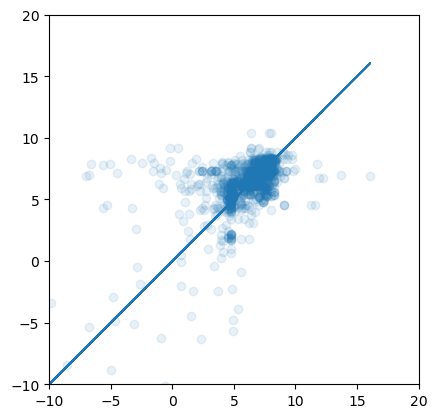

In [84]:
# Collect the sigma_lnks, RMG_k, mech_ks in to an array
RMG_ks = [x['RMG_k'] for x in data_entries]
mech_ks = [x['mech_k'] for x in data_entries]

plt.plot(np.log10(mech_ks), np.log10(mech_ks))
plt.scatter(np.log10(mech_ks), np.log10(RMG_ks), alpha=0.1)

plt.xlim([-10, 20])
plt.ylim([-10, 20])

ax = plt.gca()
ax.set_aspect('equal', 'box')

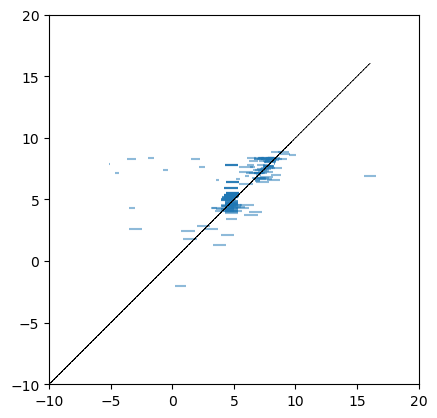

In [95]:
# plot all the low sigma_k examples
RMG_ks = [x['RMG_k'] for x in data_entries if x['sigma_lnk'] < 1.329]
mech_ks = [x['mech_k'] for x in data_entries if x['sigma_lnk'] < 1.329]
sigmas = [np.log10(np.exp(x['sigma_lnk'])) for x in data_entries if x['sigma_lnk'] < 1.329]


plt.plot(np.log10(mech_ks), np.log10(mech_ks), color='black', linewidth=0.5, linestyle='dashed')
# plt.scatter(np.log10(mech_ks), np.log10(RMG_ks), alpha=0.1)


plt.errorbar(np.log10(mech_ks), np.log10(RMG_ks), xerr=sigmas, fmt='none', alpha=0.5)

plt.xlim([-10, 20])
plt.ylim([-10, 20])

ax = plt.gca()
ax.set_aspect('equal', 'box')

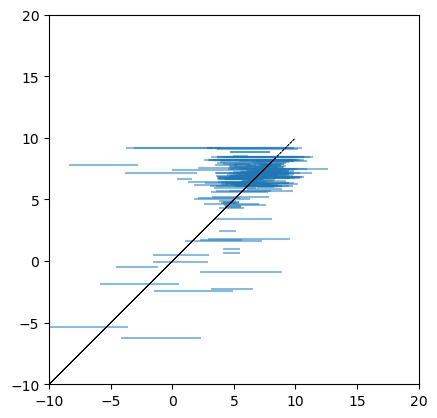

In [96]:
# plot all the medium sigma_k examples
RMG_ks = [x['RMG_k'] for x in data_entries if (x['sigma_lnk'] >= 1.329 and x['sigma_lnk'] <= 10)]
mech_ks = [x['mech_k'] for x in data_entries if (x['sigma_lnk'] >= 1.329 and x['sigma_lnk'] <= 10)]
sigmas = [np.log10(np.exp(x['sigma_lnk'])) for x in data_entries if (x['sigma_lnk'] >= 1.329 and x['sigma_lnk'] <= 10)]


plt.plot(np.log10(mech_ks), np.log10(mech_ks), color='black', linewidth=0.5, linestyle='dashed')
# plt.scatter(np.log10(mech_ks), np.log10(RMG_ks), alpha=0.1)


plt.errorbar(np.log10(mech_ks), np.log10(RMG_ks), xerr=sigmas, fmt='none', alpha=0.5)

plt.xlim([-10, 20])
plt.ylim([-10, 20])

ax = plt.gca()
ax.set_aspect('equal', 'box')

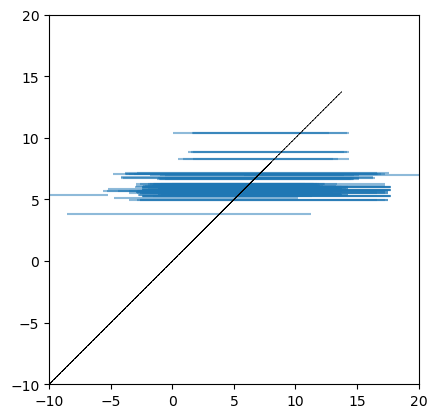

In [97]:
# plot all the high sigma_k examples
RMG_ks = [x['RMG_k'] for x in data_entries if x['sigma_lnk'] > 10]
mech_ks = [x['mech_k'] for x in data_entries if x['sigma_lnk'] > 10]
sigmas = [np.log10(np.exp(x['sigma_lnk'])) for x in data_entries if x['sigma_lnk'] > 10]


plt.plot(np.log10(mech_ks), np.log10(mech_ks), color='black', linewidth=0.5, linestyle='dashed')
# plt.scatter(np.log10(mech_ks), np.log10(RMG_ks), alpha=0.1)


plt.errorbar(np.log10(mech_ks), np.log10(RMG_ks), xerr=sigmas, fmt='none', alpha=0.5)

plt.xlim([-10, 20])
plt.ylim([-10, 20])

ax = plt.gca()
ax.set_aspect('equal', 'box')

In [54]:
len(data_entries)

1245

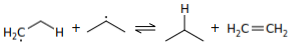

In [40]:
display(rxns[2])

In [37]:
display(my_rxn)

In [36]:
kinetics.to_arrhenius(1000).Ea.value_si

27651.112768725176

'Root_1R->H_N-2R->S_N-2CHNO->H_N-2CNO-inRing_N-2CNO->O'

In [25]:
my_rxn.degeneracy = fam_rxn_list[0].degeneracy

In [26]:
my_rxn.degeneracy

2.0

In [24]:
my_rxn.kinetics

Arrhenius(A=(9.6e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))

In [23]:
fam_rxn_list[0].degeneracy

2.0

In [16]:
for i in range(len(reaction_list7)):
    if reaction_list7[i].is_isomorphic(reaction_listA[280]):
        print(i)

In [17]:
display(reaction_listA[280])

In [ ]:
i

In [ ]:
display(my_rxn)

In [ ]:
reaction_listA[i].re

In [ ]:
r.kinetics.uncertainty.get_expected_log_uncertainty()

In [ ]:
r.degeneracy

In [ ]:
reaction_listA[0].reactants[0].molecule[0].merge()

In [ ]:
for r in rxn.reactants[1:]:
                rmol = rmol.merge(r.molecule[0])


In [ ]:
reaction_listA[0].is_forward

In [ ]:
database.kinetics.families[family].add_atom_labels_for_reaction(n)

In [ ]:
template_labels = database.kinetics.families[family].get_reaction_template_labels(fam_rxn_list[0])

In [ ]:
        

        
        template = database.kinetics.families[family].retrieve_template(template_labels)

        kinetics = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=my_rxn.degeneracy)[0]

    

In [ ]:
auto_gen_families.keys()

In [ ]:
len(rxns)

In [ ]:
database.kinetics.families[family].extract_source_from_comments(r)[1][1]

In [ ]:
r = rmgpy.reaction.Reaction()
r.kinetics = kinetics

In [ ]:
database.kinetics.families[family].extract_source_from_comments(r)

In [ ]:
kinetics

In [ ]:
dir(database.kinetics.families[family].rules.entries[node][0])

In [ ]:
database.kinetics.families[family].rules.entries[node][0].data

In [ ]:
template[0].label

In [ ]:
fam_rxn_list[0].is_forward

In [ ]:
fam_rxn_list[0].kinetics

In [ ]:
disps = []
# for i in range(400):
for i in range(len(reaction_listA)):
    # see if the reaction matches an RMG family...
    my_rxn = copy.deepcopy(reaction_listA[i])
    try:
        database.kinetics.families['Disproportionation'].add_atom_labels_for_reaction(my_rxn)
    except rmgpy.exceptions.ActionError:
#         print(f'Reaction {i} is not a Disp reaction')
        continue
    
    disps.append(i)
    print(f'Reaction {i} is a Disp reaction')
    

In [ ]:
reaction_listA[0]

In [ ]:
database.kinetics.families['Disproportionation'].add_atom_labels_for_reaction(reaction_listA[0])

In [ ]:
z = 80
print(reaction_list[z].family)
display(reaction_list[z])
print(reaction_list[z].kinetics)

my_rxn = copy.deepcopy(reaction_list[z])

print(my_rxn.reactants[0].molecule[0].get_all_labeled_atoms())
print(my_rxn.reactants[1].molecule[0].get_all_labeled_atoms())
print()

database.kinetics.families[reaction_list[z].family].add_atom_labels_for_reaction(my_rxn)

print(my_rxn.reactants[0].molecule[0].get_all_labeled_atoms())
print(my_rxn.reactants[1].molecule[0].get_all_labeled_atoms())
print()

template_labels = database.kinetics.families[my_rxn.family].get_reaction_template_labels(my_rxn)
print(template_labels)
template = database.kinetics.families[my_rxn.family].retrieve_template(template_labels)
print(template)
print()

kinetics = database.kinetics.families[my_rxn.family].get_kinetics_for_template(template, degeneracy=my_rxn.degeneracy)[0]
print(kinetics)

plot_kinetics([reaction_list[z], my_rxn], labels=['Original', 'refitted'])